In [86]:
# DC Crime Incidents Analysis (2019-2025)
# Year-by-year, citywide, ward, and ward-by-crime analysis with CSV outputs and map visualizations
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
import glob
import os
from pathlib import Path

In [87]:
# Load federal locations and crime incident files
data_folder = '../data/raw/'
feds_locations = pd.read_csv(os.path.join(data_folder, 'DC geolocations - FOR MAP.csv'))

# standardize column names
feds_locations.columns = feds_locations.columns.str.upper().str.replace(' ', '_')

# delete any column that contains all missing values
feds_locations = feds_locations.dropna(axis=1, how='all')

# drop column NAME_LABELS_ and rename last column to LOCATION_NAME
feds_locations = feds_locations.drop(columns=['NAME_LABELS_'])
feds_locations = feds_locations.rename(columns={feds_locations.columns[-1]: 'LOCATION_NAME'})

# delete any record where LOCATION_MAP is missing
# feds_locations = feds_locations.dropna(subset=['LOCATION_MAP'])

feds_locations.head()


,LAT,LONG,AGENCY_COLOR,AGENCIES,LOCATION_NAME
0,38.898520,-77.027903,Orange,National Guard,Metro Center station
1,38.901337,-77.032178,Orange,National Guard,McPherson Square Metro station
2,38.875388,-77.005343,Orange,National Guard,Navy Yard
3,38.928875,-77.032664,Black,Multiple agencies: FBI and ICE,Columbia Heights Metro station
4,38.884361,-76.995669,Orange,National Guard,Eastern Market Metro station


In [88]:
# Load and concatenate all crime incident files (2019-2025)
# Make sure to manually load 2025 from here now and then
# https://opendata.dc.gov/datasets/DCGIS::crime-incidents-in-2025/explore

csv_files = sorted(glob.glob(os.path.join(data_folder, 'Crime_Incidents_in_20*.csv')))
if not csv_files:
    raise FileNotFoundError("No crime incident files found for the specified years.")
crime_incidents = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

# Deduplicate records
before = len(crime_incidents)
crime_incidents = crime_incidents.drop_duplicates()
after = len(crime_incidents)
print(f"Deduplication complete. Dropped {before - after} duplicate records.")

crime_incidents.head()

Deduplication complete. Dropped 0 duplicate records.


,X,Y,CCN,REPORT_DAT,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,...,BLOCK_GROUP,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,OCTO_RECORD_ID
0,400134.00,130213.00,19133977,2019/07/31 02:06:18+00,EVENING,GUN,ASSAULT W/DANGEROUS WEAPON,3301 - 3699 BLOCK OF 6TH STREET SE,400134.00,130213.00,...,009804 2,9804.0,Precinct 122,38.839713,-76.998457,NaN,2019/07/30 22:42:17+00,2019/07/30 22:55:26+00,717509953,NaN
1,397228.00,137798.00,19046953,2019/03/20 16:35:01+00,DAY,OTHERS,THEFT/OTHER,1300 - 1399 BLOCK OF 14TH STREET NW,397228.00,137798.00,...,005203 2,5203.0,Precinct 17,38.908037,-77.031960,NaN,2019/03/20 15:30:24+00,2019/03/20 15:45:03+00,717509954,NaN
2,397705.17,141966.76,19051853,2019/03/28 02:08:24+00,EVENING,OTHERS,THEFT/OTHER,4500 - 4599 BLOCK OF GEORGIA AVENUE NW,397705.17,141966.76,...,002400 2,2400.0,Precinct 46,38.945592,-77.026472,NaN,2019/03/27 18:57:00+00,2019/03/28 02:17:53+00,717509955,NaN
3,402152.00,140253.00,19206304,2019/11/18 10:39:13+00,MIDNIGHT,OTHERS,THEFT F/AUTO,2000 - 2199 BLOCK OF JACKSON STREET NE,402152.00,140253.00,...,009400 2,9400.0,Precinct 70,38.930155,-76.975181,NaN,2019/11/17 19:00:24+00,2019/11/18 07:45:26+00,717509956,NaN
4,396307.07,137186.46,19079495,2019/05/09 12:21:18+00,DAY,OTHERS,THEFT/OTHER,1800 - 1899 BLOCK OF K STREET NW,396307.07,137186.46,...,010700 1,10700.0,Precinct 17,38.902525,-77.042574,GOLDEN TRIANGLE,2019/05/08 22:30:40+00,2019/05/09 10:45:37+00,717509960,NaN


In [89]:
# Standardize columns and clean up date columns
crime_incidents.columns = [col.strip().upper().replace(' ', '_') for col in crime_incidents.columns]
crime_incidents = crime_incidents.rename(columns={'REPORT_DAT': 'REPORT_DATE'})
for col in ['REPORT_DATE', 'START_DATE', 'END_DATE']:
    if col in crime_incidents.columns:
        crime_incidents[col] = pd.to_datetime(crime_incidents[col], errors='coerce')
crime_incidents['YEAR'] = crime_incidents['REPORT_DATE'].dt.year.astype(str)
crime_incidents.head()

,X,Y,CCN,REPORT_DATE,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,...,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,OCTO_RECORD_ID,YEAR
0,400134.00,130213.00,19133977,2019-07-31 02:06:18+00:00,EVENING,GUN,ASSAULT W/DANGEROUS WEAPON,3301 - 3699 BLOCK OF 6TH STREET SE,400134.00,130213.00,...,9804.0,Precinct 122,38.839713,-76.998457,NaN,2019-07-30 22:42:17+00:00,2019-07-30 22:55:26+00:00,717509953,NaN,2019
1,397228.00,137798.00,19046953,2019-03-20 16:35:01+00:00,DAY,OTHERS,THEFT/OTHER,1300 - 1399 BLOCK OF 14TH STREET NW,397228.00,137798.00,...,5203.0,Precinct 17,38.908037,-77.031960,NaN,2019-03-20 15:30:24+00:00,2019-03-20 15:45:03+00:00,717509954,NaN,2019
2,397705.17,141966.76,19051853,2019-03-28 02:08:24+00:00,EVENING,OTHERS,THEFT/OTHER,4500 - 4599 BLOCK OF GEORGIA AVENUE NW,397705.17,141966.76,...,2400.0,Precinct 46,38.945592,-77.026472,NaN,2019-03-27 18:57:00+00:00,2019-03-28 02:17:53+00:00,717509955,NaN,2019
3,402152.00,140253.00,19206304,2019-11-18 10:39:13+00:00,MIDNIGHT,OTHERS,THEFT F/AUTO,2000 - 2199 BLOCK OF JACKSON STREET NE,402152.00,140253.00,...,9400.0,Precinct 70,38.930155,-76.975181,NaN,2019-11-17 19:00:24+00:00,2019-11-18 07:45:26+00:00,717509956,NaN,2019
4,396307.07,137186.46,19079495,2019-05-09 12:21:18+00:00,DAY,OTHERS,THEFT/OTHER,1800 - 1899 BLOCK OF K STREET NW,396307.07,137186.46,...,10700.0,Precinct 17,38.902525,-77.042574,GOLDEN TRIANGLE,2019-05-08 22:30:40+00:00,2019-05-09 10:45:37+00:00,717509960,NaN,2019


In [90]:
# Standardize columns and clean up date columns
crime_incidents.columns = [col.strip().upper().replace(' ', '_') for col in crime_incidents.columns]
crime_incidents = crime_incidents.rename(columns={'REPORT_DAT': 'REPORT_DATE'})
for col in ['REPORT_DATE', 'START_DATE', 'END_DATE']:
    if col in crime_incidents.columns:
        crime_incidents[col] = pd.to_datetime(crime_incidents[col], errors='coerce')
# Add YEAR column
crime_incidents['YEAR'] = crime_incidents['REPORT_DATE'].dt.year.astype(str)
# convert WARD to integer
#crime_incidents['WARD'] = crime_incidents['WARD'].astype(int)
# Save cleaned incidents to CSV
crime_incidents.to_csv(os.path.join(data_folder, '../processed/crime_incidents.csv'), index=False)
crime_incidents.head()

,X,Y,CCN,REPORT_DATE,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,...,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,OCTO_RECORD_ID,YEAR
0,400134.00,130213.00,19133977,2019-07-31 02:06:18+00:00,EVENING,GUN,ASSAULT W/DANGEROUS WEAPON,3301 - 3699 BLOCK OF 6TH STREET SE,400134.00,130213.00,...,9804.0,Precinct 122,38.839713,-76.998457,NaN,2019-07-30 22:42:17+00:00,2019-07-30 22:55:26+00:00,717509953,NaN,2019
1,397228.00,137798.00,19046953,2019-03-20 16:35:01+00:00,DAY,OTHERS,THEFT/OTHER,1300 - 1399 BLOCK OF 14TH STREET NW,397228.00,137798.00,...,5203.0,Precinct 17,38.908037,-77.031960,NaN,2019-03-20 15:30:24+00:00,2019-03-20 15:45:03+00:00,717509954,NaN,2019
2,397705.17,141966.76,19051853,2019-03-28 02:08:24+00:00,EVENING,OTHERS,THEFT/OTHER,4500 - 4599 BLOCK OF GEORGIA AVENUE NW,397705.17,141966.76,...,2400.0,Precinct 46,38.945592,-77.026472,NaN,2019-03-27 18:57:00+00:00,2019-03-28 02:17:53+00:00,717509955,NaN,2019
3,402152.00,140253.00,19206304,2019-11-18 10:39:13+00:00,MIDNIGHT,OTHERS,THEFT F/AUTO,2000 - 2199 BLOCK OF JACKSON STREET NE,402152.00,140253.00,...,9400.0,Precinct 70,38.930155,-76.975181,NaN,2019-11-17 19:00:24+00:00,2019-11-18 07:45:26+00:00,717509956,NaN,2019
4,396307.07,137186.46,19079495,2019-05-09 12:21:18+00:00,DAY,OTHERS,THEFT/OTHER,1800 - 1899 BLOCK OF K STREET NW,396307.07,137186.46,...,10700.0,Precinct 17,38.902525,-77.042574,GOLDEN TRIANGLE,2019-05-08 22:30:40+00:00,2019-05-09 10:45:37+00:00,717509960,NaN,2019


In [91]:
# List unique offense types
offense_variants = crime_incidents['OFFENSE'].unique()
pd.DataFrame({'OFFENSE': offense_variants}).head(10)

,OFFENSE
0,ASSAULT W/DANGEROUS WEAPON
1,THEFT/OTHER
2,THEFT F/AUTO
3,ROBBERY
4,MOTOR VEHICLE THEFT
5,SEX ABUSE
6,HOMICIDE
7,BURGLARY
8,ARSON


In [92]:
# Yearly offense count (citywide)
crime_offense_yearly = crime_incidents.groupby(['OFFENSE', 'YEAR']).size().unstack(fill_value=0)
crime_offense_yearly.to_csv(os.path.join(data_folder, '../processed/crime_offense_yearly.csv'))
crime_offense_yearly.head(10)

YEAR,2019,2020,2021,2022,2023,2024,2025
OFFENSE,,,,,,,
ARSON,8,13,4,4,11,4,4
ASSAULT W/DANGEROUS WEAPON,1573,1632,1658,1379,1404,1025,557
BURGLARY,1274,1443,1174,1049,1092,1005,464
HOMICIDE,166,198,222,203,274,187,101
MOTOR VEHICLE THEFT,2187,3260,3479,3742,6791,5128,2993
ROBBERY,2235,1998,2038,2074,3463,2110,918
SEX ABUSE,199,178,189,182,192,142,57
THEFT F/AUTO,10741,8285,8655,7762,7750,6679,3870
THEFT/OTHER,15572,10929,10892,10765,13267,13001,7420


In [93]:
# Year-to-date offense count (citywide, using min/max date in 2025)
max_2025_date = crime_incidents.loc[crime_incidents['YEAR'] == '2025', 'REPORT_DATE'].max()
min_2025_date = crime_incidents.loc[crime_incidents['YEAR'] == '2025', 'REPORT_DATE'].min()
min_md = (min_2025_date.month, min_2025_date.day)
max_md = (max_2025_date.month, max_2025_date.day)
def is_within_period(row):
    if pd.isnull(row['REPORT_DATE']): return False
    md = (row['REPORT_DATE'].month, row['REPORT_DATE'].day)
    return (md >= min_md) and (md <= max_md)
filtered = crime_incidents[crime_incidents.apply(is_within_period, axis=1)]
filtered = filtered[filtered['YEAR'].isin([str(y) for y in range(2019, 2026)])]
crime_offense_ytd = filtered.groupby(['OFFENSE', 'YEAR']).size().unstack(fill_value=0)
crime_offense_ytd.to_csv(os.path.join(data_folder, '../processed/crime_offense_ytd.csv'))
crime_offense_ytd.head()

YEAR,2019,2020,2021,2022,2023,2024,2025
OFFENSE,,,,,,,
ARSON,7,11,4,3,8,3,4
ASSAULT W/DANGEROUS WEAPON,1013,1047,995,904,931,694,557
BURGLARY,821,1027,667,683,702,586,464
HOMICIDE,106,118,127,131,171,115,101
MOTOR VEHICLE THEFT,1329,1822,2122,2176,4649,3081,2993


In [94]:
# Year-to-date offense count since August 11 (citywide)
max_2025_date = crime_incidents.loc[crime_incidents['YEAR'] == '2025', 'REPORT_DATE'].max()
min_2025_date = pd.Timestamp(year=2025, month=8, day=11)
min_md = (min_2025_date.month, min_2025_date.day)
max_md = (max_2025_date.month, max_2025_date.day)
def is_within_period(row):
    if pd.isnull(row['REPORT_DATE']): return False
    md = (row['REPORT_DATE'].month, row['REPORT_DATE'].day)
    return (md >= min_md) and (md <= max_md)
filtered = crime_incidents[crime_incidents.apply(is_within_period, axis=1)]
filtered = filtered[filtered['YEAR'].isin([str(y) for y in range(2023, 2026)])]
crime_offense_since_aug11 = filtered.groupby(['OFFENSE', 'YEAR']).size().unstack(fill_value=0)
crime_offense_since_aug11.to_csv(os.path.join(data_folder, '../processed/crime_offense_since_aug11.csv'))
crime_offense_since_aug11.head()

YEAR,2023,2024,2025
OFFENSE,,,
ASSAULT W/DANGEROUS WEAPON,42,28,19
BURGLARY,35,42,26
HOMICIDE,8,3,3
MOTOR VEHICLE THEFT,208,179,92
ROBBERY,121,69,17


In [95]:
# Crime counts by offense type, ward, and year
crime_by_ward_year_offense = crime_incidents.groupby(['WARD', 'YEAR', 'OFFENSE']).size().reset_index(name='COUNT')
crime_by_ward_year_offense.to_csv(os.path.join(data_folder, '../processed/crime_by_ward_year_offense_comprehensive.csv'), index=False)
crime_by_ward_year_offense.head()

,WARD,YEAR,OFFENSE,COUNT
0,1.0,2019,ARSON,1
1,1.0,2019,ASSAULT W/DANGEROUS WEAPON,163
2,1.0,2019,BURGLARY,135
3,1.0,2019,HOMICIDE,16
4,1.0,2019,MOTOR VEHICLE THEFT,248


In [96]:
# Homicides by ward and year, with totals
homicides = crime_incidents[crime_incidents['OFFENSE'] == 'HOMICIDE']
homicides_by_ward_year = homicides.groupby(['WARD', 'YEAR']).size().unstack(fill_value=0)
homicides_by_ward_year.index = homicides_by_ward_year.index.astype(int)
homicides_by_ward_year['TOTAL_ALL_YEARS'] = homicides_by_ward_year.sum(axis=1)
totals_row = homicides_by_ward_year.sum(axis=0)
totals_row.name = 'TOTAL_ALL_WARDS'
homicides_with_totals = pd.concat([homicides_by_ward_year, totals_row.to_frame().T])
homicides_with_totals.to_csv(os.path.join(data_folder, '../processed/homicides_by_ward_year_with_totals.csv'))
homicides_with_totals.head()

YEAR,2019,2020,2021,2022,2023,2024,2025,TOTAL_ALL_YEARS
1,16,14,13,14,28,15,7,107
2,0,9,7,11,11,11,4,53
3,3,3,2,2,2,2,2,16
4,6,9,20,9,16,15,3,78
5,18,25,25,33,36,23,11,171


In [97]:
# Create CSVs for each major crime type with all incident details
crime_types = {
    'all_homicides': crime_incidents[crime_incidents['OFFENSE'] == 'HOMICIDE'],
    'all_assaults': crime_incidents[crime_incidents['OFFENSE'] == 'ASSAULT W/DANGEROUS WEAPON'],
    'all_burglaries': crime_incidents[crime_incidents['OFFENSE'] == 'BURGLARY'],
    'all_robberies': crime_incidents[crime_incidents['OFFENSE'] == 'ROBBERY'],
    'all_car_thefts': crime_incidents[crime_incidents['OFFENSE'] == 'MOTOR VEHICLE THEFT'],
    'all_gun_crimes': crime_incidents[crime_incidents['METHOD'].str.contains('GUN', case=False, na=False)]
}
for name, df in crime_types.items():
    df.to_csv(os.path.join(data_folder, f'../processed/{name}.csv'), index=False)
    print(f'{name}: {len(df)} records')
    display(df.head())

all_homicides: 1351 records


,X,Y,CCN,REPORT_DATE,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,...,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,OCTO_RECORD_ID,YEAR
17,400134.00,130213.00,19035602,2019-09-12 04:00:00+00:00,MIDNIGHT,OTHERS,HOMICIDE,3301 - 3699 BLOCK OF 6TH STREET SE,400134.00,130213.00,...,9804.0,Precinct 122,38.839713,-76.998457,NaN,2019-02-28 00:41:51+00:00,2019-03-01 11:00:49+00:00,717510011,NaN,2019
27,402539.00,132397.00,19058463,2019-04-07 04:00:00+00:00,MIDNIGHT,GUN,HOMICIDE,2421 - 2499 BLOCK OF WAGNER STREET SE,402539.00,132397.00,...,7502.0,Precinct 134,38.859384,-76.970747,NaN,2019-04-07 05:34:55+00:00,NaT,717510032,NaN,2019
71,399099.00,128076.00,17084415,2019-01-28 05:00:00+00:00,MIDNIGHT,GUN,HOMICIDE,130 - 199 BLOCK OF IRVINGTON STREET SW,399099.00,128076.00,...,10900.0,Precinct 126,38.820461,-77.010375,NaN,2017-05-20 02:58:53+00:00,2017-05-20 06:26:45+00:00,717510466,NaN,2019
111,400588.00,129470.00,19079851,2019-05-09 04:00:00+00:00,MIDNIGHT,GUN,HOMICIDE,800 - 899 BLOCK OF XENIA STREET SE,400588.00,129470.00,...,9801.0,Precinct 121,38.833020,-76.993228,NaN,2019-05-09 21:16:26+00:00,2019-05-09 21:18:07+00:00,717527111,NaN,2019
331,399214.79,137753.75,19008438,2019-01-15 05:00:00+00:00,MIDNIGHT,GUN,HOMICIDE,1200 - 1499 BLOCK OF NORTH CAPITOL STREET,399214.79,137753.75,...,4704.0,Precinct 1,38.907643,-77.009053,NaN,2019-01-15 20:05:16+00:00,2019-01-15 20:07:52+00:00,717528993,NaN,2019


all_assaults: 9228 records


,X,Y,CCN,REPORT_DATE,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,...,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,OCTO_RECORD_ID,YEAR
0,400134.0,130213.0,19133977,2019-07-31 02:06:18+00:00,EVENING,GUN,ASSAULT W/DANGEROUS WEAPON,3301 - 3699 BLOCK OF 6TH STREET SE,400134.0,130213.0,...,9804.0,Precinct 122,38.839713,-76.998457,NaN,2019-07-30 22:42:17+00:00,2019-07-30 22:55:26+00:00,717509953,NaN,2019
8,406835.0,136726.0,19000356,2019-01-01 18:09:12+00:00,DAY,GUN,ASSAULT W/DANGEROUS WEAPON,5500 - 5599 BLOCK OF NANNIE HELEN BURROUGHS AV...,406835.0,136726.0,...,7807.0,Precinct 95,38.898358,-76.921207,NaN,2019-01-01 16:10:16+00:00,NaT,717509994,NaN,2019
55,402911.0,131429.0,19076965,2019-05-05 19:22:13+00:00,EVENING,KNIFE,ASSAULT W/DANGEROUS WEAPON,3100 - 3299 BLOCK OF BUENA VISTA TERRACE SE,402911.0,131429.0,...,7408.0,Precinct 115,38.850662,-76.966465,NaN,2019-05-05 17:38:26+00:00,2019-05-05 18:23:26+00:00,717510227,NaN,2019
59,403741.0,135089.0,19196335,2019-11-02 12:29:36+00:00,DAY,GUN,ASSAULT W/DANGEROUS WEAPON,3400 - 3499 BLOCK OF ELY PLACE SE,403741.0,135089.0,...,7703.0,Precinct 107,38.883630,-76.956883,NaN,2019-11-02 09:52:56+00:00,2019-11-02 12:29:44+00:00,717510247,NaN,2019
62,396705.0,140274.0,19156903,2019-09-04 09:19:06+00:00,MIDNIGHT,KNIFE,ASSAULT W/DANGEROUS WEAPON,3140 - 3172 BLOCK OF MOUNT PLEASANT STREET NW,396705.0,140274.0,...,2702.0,Precinct 39,38.930340,-77.038002,NaN,2019-09-04 06:35:34+00:00,2019-09-04 09:19:48+00:00,717510252,NaN,2019


all_burglaries: 7501 records


,X,Y,CCN,REPORT_DATE,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,...,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,OCTO_RECORD_ID,YEAR
97,395814.0,138839.0,19070892,2019-04-26 13:57:08+00:00,DAY,OTHERS,BURGLARY,2100 - 2199 BLOCK OF WYOMING AVENUE NW,395814.0,138839.0,...,4100.0,Precinct 13,38.917409,-77.048269,NaN,2019-04-26 00:00:57+00:00,2019-04-26 10:45:31+00:00,717527096,NaN,2019
118,398416.0,138538.0,19013436,2019-01-24 09:46:21+00:00,MIDNIGHT,OTHERS,BURGLARY,420 - 499 BLOCK OF FLORIDA AVENUE NW,398416.0,138538.0,...,3400.0,Precinct 37,38.914706,-77.018264,NaN,2019-01-24 07:02:27+00:00,2019-01-24 07:36:35+00:00,717527163,NaN,2019
141,402887.0,134282.0,19017666,2019-01-31 07:37:39+00:00,MIDNIGHT,OTHERS,BURGLARY,2900 - 2943 BLOCK OF NELSON PLACE SE,402887.0,134282.0,...,7709.0,Precinct 111,38.876364,-76.966729,NaN,2019-01-31 06:00:34+00:00,2019-01-31 06:11:01+00:00,717527250,NaN,2019
144,396670.0,139844.0,19018257,2019-02-01 05:57:42+00:00,MIDNIGHT,OTHERS,BURGLARY,1601 - 1699 BLOCK OF ARGONNE PLACE NW,396670.0,139844.0,...,3901.0,Precinct 35,38.926466,-77.038403,NaN,2019-02-01 03:24:51+00:00,2019-02-01 04:27:01+00:00,717527253,NaN,2019
158,399950.0,139209.0,19031042,2019-02-22 16:25:03+00:00,DAY,OTHERS,BURGLARY,2300 BLOCK OF 4TH STREET NE,399950.0,139209.0,...,9204.0,Precinct 74,38.920753,-77.000577,NaN,2019-02-21 22:30:03+00:00,2019-02-22 12:30:34+00:00,717527424,NaN,2019


all_robberies: 14836 records


,X,Y,CCN,REPORT_DATE,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,...,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,OCTO_RECORD_ID,YEAR
10,396372.0,137666.0,19136888,2019-08-04 09:10:47+00:00,MIDNIGHT,OTHERS,ROBBERY,1218 - 1299 BLOCK OF CONNECTICUT AVENUE NW,396372.0,137666.0,...,10700.0,Precinct 17,38.906845,-77.041828,GOLDEN TRIANGLE,2019-08-04 08:06:01+00:00,2019-08-04 08:07:58+00:00,717510002,NaN,2019
35,401840.0,136678.0,19109633,2019-06-23 22:09:44+00:00,EVENING,GUN,ROBBERY,1700 - 1799 BLOCK OF GALES STREET NE,401840.0,136678.0,...,7901.0,Precinct 81,38.897950,-76.978789,NaN,2019-06-23 18:59:23+00:00,2019-06-23 23:15:32+00:00,717510089,NaN,2019
36,398099.0,138551.0,19158059,2019-09-05 22:50:24+00:00,EVENING,OTHERS,ROBBERY,1800 - 1899 BLOCK OF 7TH STREET NW,398099.0,138551.0,...,4402.0,Precinct 137,38.914823,-77.021920,NaN,2019-08-31 04:45:15+00:00,2019-08-31 04:46:34+00:00,717510090,NaN,2019
50,397228.0,137253.0,19149594,2019-08-23 23:26:45+00:00,EVENING,OTHERS,ROBBERY,1000 - 1099 BLOCK OF 14TH STREET NW,397228.0,137253.0,...,10100.0,Precinct 129,38.903128,-77.031958,DOWNTOWN,2019-08-23 21:44:32+00:00,NaT,717510195,NaN,2019
60,402530.0,136674.0,19086273,2019-05-20 00:20:17+00:00,EVENING,OTHERS,ROBBERY,2500 - 2598 BLOCK OF BENNING ROAD NE,402530.0,136674.0,...,11100.0,Precinct 79,38.897913,-76.970835,NaN,2019-05-19 22:56:15+00:00,2019-05-20 00:20:27+00:00,717510250,NaN,2019


all_car_thefts: 27580 records


,X,Y,CCN,REPORT_DATE,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,...,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,OCTO_RECORD_ID,YEAR
11,401542.0,135210.0,19169693,2019-09-23 15:17:47+00:00,DAY,OTHERS,MOTOR VEHICLE THEFT,300 - 399 BLOCK OF 16TH STREET SE,401542.0,135210.0,...,6802.0,Precinct 87,38.884727,-76.982227,NaN,2019-09-23 14:21:37+00:00,2019-09-23 14:30:33+00:00,717510003,NaN,2019
38,399852.0,143321.0,19110361,2019-06-25 01:01:33+00:00,EVENING,OTHERS,MOTOR VEHICLE THEFT,300 - 399 BLOCK OF RIGGS ROAD NE,399852.0,143321.0,...,9505.0,Precinct 65,38.957795,-77.001708,NaN,2019-06-24 18:55:20+00:00,2019-06-24 18:57:05+00:00,717510092,NaN,2019
40,397564.0,137620.0,19093350,2019-05-30 08:27:10+00:00,MIDNIGHT,OTHERS,MOTOR VEHICLE THEFT,1200 - 1299 BLOCK OF 12TH STREET NW,397564.0,137620.0,...,5004.0,Precinct 17,38.906435,-77.028085,NaN,2019-05-30 07:44:09+00:00,2019-05-30 08:27:20+00:00,717510094,NaN,2019
81,397846.0,143036.0,19001454,2019-01-03 13:23:44+00:00,DAY,OTHERS,MOTOR VEHICLE THEFT,800 - 899 BLOCK OF JEFFERSON STREET NW,397846.0,143036.0,...,2101.0,Precinct 56,38.955225,-77.024851,NaN,2019-01-03 00:00:44+00:00,2019-01-03 11:00:22+00:00,717524983,NaN,2019
123,393813.0,141878.0,19002935,2019-01-05 19:17:11+00:00,DAY,OTHERS,MOTOR VEHICLE THEFT,3604 - 3699 BLOCK OF WARREN STREET NW,393813.0,141878.0,...,1200.0,Precinct 33,38.944774,-77.071370,NaN,2019-01-05 04:30:05+00:00,NaT,717527180,NaN,2019


all_gun_crimes: 14818 records


,X,Y,CCN,REPORT_DATE,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,...,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,OCTO_RECORD_ID,YEAR
0,400134.0,130213.0,19133977,2019-07-31 02:06:18+00:00,EVENING,GUN,ASSAULT W/DANGEROUS WEAPON,3301 - 3699 BLOCK OF 6TH STREET SE,400134.0,130213.0,...,9804.0,Precinct 122,38.839713,-76.998457,NaN,2019-07-30 22:42:17+00:00,2019-07-30 22:55:26+00:00,717509953,NaN,2019
8,406835.0,136726.0,19000356,2019-01-01 18:09:12+00:00,DAY,GUN,ASSAULT W/DANGEROUS WEAPON,5500 - 5599 BLOCK OF NANNIE HELEN BURROUGHS AV...,406835.0,136726.0,...,7807.0,Precinct 95,38.898358,-76.921207,NaN,2019-01-01 16:10:16+00:00,NaT,717509994,NaN,2019
27,402539.0,132397.0,19058463,2019-04-07 04:00:00+00:00,MIDNIGHT,GUN,HOMICIDE,2421 - 2499 BLOCK OF WAGNER STREET SE,402539.0,132397.0,...,7502.0,Precinct 134,38.859384,-76.970747,NaN,2019-04-07 05:34:55+00:00,NaT,717510032,NaN,2019
35,401840.0,136678.0,19109633,2019-06-23 22:09:44+00:00,EVENING,GUN,ROBBERY,1700 - 1799 BLOCK OF GALES STREET NE,401840.0,136678.0,...,7901.0,Precinct 81,38.897950,-76.978789,NaN,2019-06-23 18:59:23+00:00,2019-06-23 23:15:32+00:00,717510089,NaN,2019
59,403741.0,135089.0,19196335,2019-11-02 12:29:36+00:00,DAY,GUN,ASSAULT W/DANGEROUS WEAPON,3400 - 3499 BLOCK OF ELY PLACE SE,403741.0,135089.0,...,7703.0,Precinct 107,38.883630,-76.956883,NaN,2019-11-02 09:52:56+00:00,2019-11-02 12:29:44+00:00,717510247,NaN,2019


In [98]:
# Create and save individual crime DataFrames for mapping and output (2025 incidents with coordinates)
crime_types = {
    'homicide_data': ('HOMICIDE', 'OFFENSE'),
    'assault_data': ('ASSAULT W/DANGEROUS WEAPON', 'OFFENSE'),
    'robbery_data': ('ROBBERY', 'OFFENSE'),
    'burglary_data': ('BURGLARY', 'OFFENSE'),
    'car_theft_data': ('MOTOR VEHICLE THEFT', 'OFFENSE'),
    'gun_crimes_data': ('GUN', 'METHOD')
}
df_2025 = crime_incidents[crime_incidents['YEAR'] == '2025']
for var_name, (value, col) in crime_types.items():
    df = df_2025[(df_2025[col] == value) & df_2025['LATITUDE'].notna() & df_2025['LONGITUDE'].notna()]
    globals()[var_name] = df
    df.to_csv(os.path.join(data_folder, f'../processed/{var_name}.csv'), index=False)
    print(f'{var_name}: {len(df)} records')
    display(df.head())

homicide_data: 101 records


,X,Y,CCN,REPORT_DATE,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,...,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,OCTO_RECORD_ID,YEAR
180916,399890.0500,134459.2800,25075196,2025-05-20 04:00:00+00:00,MIDNIGHT,GUN,HOMICIDE,1000 - 1099 BLOCK OF 3RD PLACE SE,399890.050000,134459.280000,...,7203.0,Precinct 131,38.877965,-77.001267,CAPITOL RIVERFRONT,2025-05-21 01:35:00+00:00,2025-05-21 01:38:00+00:00,784579411,NaN,2025
180944,397884.6700,141009.4700,25062803,2025-04-29 04:00:00+00:00,MIDNIGHT,GUN,HOMICIDE,3700 - 3799 BLOCK OF GEORGIA AVENUE NW,397884.670000,141009.470000,...,2503.0,Precinct 49,38.936969,-77.024399,NaN,2025-04-30 01:01:00+00:00,2025-04-30 01:04:00+00:00,784579531,NaN,2025
180993,401627.9370,132937.3269,25052409,2025-04-11 04:00:00+00:00,MIDNIGHT,OTHERS,HOMICIDE,1600 - 1699 BLOCK OF V STREET SE,401627.936959,132937.326937,...,7504.0,Precinct 114,38.864253,-76.981242,NaN,2025-04-11 03:18:00+00:00,2025-04-11 03:19:00+00:00,784579789,NaN,2025
181341,406827.3300,136094.5500,22058767,2025-06-30 04:00:00+00:00,MIDNIGHT,GUN,HOMICIDE,200 - 399 BLOCK OF 56TH STREET NE,406827.330000,136094.550000,...,7808.0,Precinct 96,38.892670,-76.921301,NaN,2022-04-28 02:21:00+00:00,2022-04-28 05:00:00+00:00,784581921,NaN,2025
181458,399489.9889,134459.5255,25017092,2025-02-04 05:00:00+00:00,MIDNIGHT,GUN,HOMICIDE,1000 - 1099 BLOCK OF 1ST STREET SE,399489.988893,134459.525530,...,7202.0,Precinct 131,38.877967,-77.005878,CAPITOL RIVERFRONT,2025-02-04 21:28:00+00:00,2025-02-05 03:56:00+00:00,784583150,NaN,2025


assault_data: 557 records


,X,Y,CCN,REPORT_DATE,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,...,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,OCTO_RECORD_ID,YEAR
173075,399454.6100,134294.6500,24202286,2025-01-01 04:34:58+00:00,MIDNIGHT,OTHERS,ASSAULT W/DANGEROUS WEAPON,56 - 99 BLOCK OF M STREET SE,399454.610000,134294.65000,...,7201.0,Precinct 131,38.876482,-77.006285,CAPITOL RIVERFRONT,2025-01-01 02:53:00+00:00,NaT,748881759,NaN,2025
180923,400891.3397,131932.5347,25102553,2025-07-08 07:26:56+00:00,MIDNIGHT,GUN,ASSAULT W/DANGEROUS WEAPON,2400 - 2699 BLOCK OF POMEROY ROAD SE,400891.339743,131932.53468,...,7406.0,Precinct 118,38.855203,-76.989731,NaN,2025-07-08 05:44:00+00:00,NaT,784579436,NaN,2025
180926,404541.4700,136535.3800,25064435,2025-05-03 01:03:59+00:00,EVENING,GUN,ASSAULT W/DANGEROUS WEAPON,4000 - 4121 BLOCK OF MINNESOTA AVENUE NE,404541.470000,136535.38000,...,7803.0,Precinct 99,38.896656,-76.947648,NaN,2025-05-02 22:29:00+00:00,2025-05-02 23:37:00+00:00,784579448,NaN,2025
180928,401535.2700,131621.8400,25112842,2025-07-26 07:40:30+00:00,MIDNIGHT,GUN,ASSAULT W/DANGEROUS WEAPON,3033 - 3098 BLOCK OF STANTON ROAD SE,401535.270000,131621.84000,...,7404.0,Precinct 117,38.852403,-76.982313,NaN,2025-07-26 03:00:00+00:00,2025-07-26 04:46:00+00:00,784579450,NaN,2025
180940,402071.3000,131148.3500,25110851,2025-07-22 21:23:52+00:00,EVENING,GUN,ASSAULT W/DANGEROUS WEAPON,1900 - 2199 BLOCK OF SAVANNAH TERRACE SE,402071.300000,131148.35000,...,7403.0,Precinct 116,38.848137,-76.976139,NaN,2025-07-22 18:58:00+00:00,2025-07-22 21:24:00+00:00,784579513,NaN,2025


robbery_data: 918 records


,X,Y,CCN,REPORT_DATE,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,...,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,OCTO_RECORD_ID,YEAR
154858,401165.8400,138586.6400,24202299,2025-01-01 04:46:14+00:00,MIDNIGHT,GUN,ROBBERY,1240 - 1399 BLOCK OF NEW YORK AVENUE NE,401165.840000,138586.640000,...,8803.0,Precinct 76,38.915145,-76.986557,NaN,2025-01-01 04:11:00+00:00,NaT,748659642,NaN,2025
165505,399277.7000,129297.4400,24202247,2025-01-01 03:23:41+00:00,EVENING,GUN,ROBBERY,1 - 99 BLOCK OF ATLANTIC STREET SW,399277.700000,129297.440000,...,9807.0,Precinct 124,38.831465,-77.008319,NaN,2025-01-01 01:30:00+00:00,2025-01-01 02:52:00+00:00,748708844,NaN,2025
174098,402887.8236,134282.6298,24202267,2025-01-01 04:25:48+00:00,MIDNIGHT,GUN,ROBBERY,2900 - 2943 BLOCK OF NELSON PLACE SE,402887.823649,134282.629818,...,7709.0,Precinct 111,38.876369,-76.966720,NaN,2025-01-01 02:55:00+00:00,NaT,748885993,NaN,2025
180911,397161.8200,140477.5200,25078342,2025-05-26 19:24:33+00:00,EVENING,GUN,ROBBERY,3413 - 3448 BLOCK OF 14TH STREET NW,397161.820000,140477.520000,...,2900.0,Precinct 41,38.932175,-77.032734,NaN,2025-05-25 19:30:00+00:00,2025-05-25 19:35:00+00:00,784579396,NaN,2025
180934,398099.2900,134865.8100,25013960,2025-01-29 23:16:25+00:00,EVENING,OTHERS,ROBBERY,600 - 699 BLOCK OF 7TH STREET SW,398099.290000,134865.810000,...,10202.0,Precinct 142,38.881625,-77.021906,SOUTHWEST,2025-01-29 20:50:00+00:00,2025-01-29 21:00:00+00:00,784579494,NaN,2025


burglary_data: 464 records


,X,Y,CCN,REPORT_DATE,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,...,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,OCTO_RECORD_ID,YEAR
155209,394534.8500,142223.6200,24202200,2025-01-01 02:15:38+00:00,EVENING,OTHERS,BURGLARY,3000 - 3199 BLOCK OF ALBEMARLE STREET NW,394534.850000,142223.620000,...,1303.0,Precinct 138,38.947892,-77.063046,NaN,2024-12-18 17:00:00+00:00,2024-12-31 23:30:00+00:00,748660547,NaN,2025
180996,396662.3700,138264.6900,25069555,2025-05-11 15:50:13+00:00,DAY,OTHERS,BURGLARY,1619 - 1699 BLOCK OF 17TH STREET NW,396662.370000,138264.690000,...,5302.0,Precinct 15,38.912240,-77.038483,NaN,2025-05-11 10:27:00+00:00,2025-05-11 12:10:00+00:00,784579807,NaN,2025
181028,399688.2400,128741.5700,25001106,2025-01-03 12:50:32+00:00,DAY,OTHERS,BURGLARY,4100 - 4530 BLOCK OF LIVINGSTON ROAD SE,399688.240000,128741.570000,...,9810.0,Precinct 125,38.826458,-77.003590,NaN,2025-01-03 12:15:00+00:00,2025-01-03 12:45:00+00:00,784580086,NaN,2025
181071,402105.7584,134033.9384,25080731,2025-05-30 22:56:00+00:00,EVENING,OTHERS,BURGLARY,2100 - 2199 BLOCK OF FAIRLAWN AVENUE SE,402105.758368,134033.938426,...,7601.0,Precinct 133,38.874131,-76.975733,NaN,2025-05-30 20:18:00+00:00,2025-05-30 22:55:00+00:00,784580464,NaN,2025
181076,401345.7200,137390.3600,25014549,2025-01-31 00:23:13+00:00,EVENING,OTHERS,BURGLARY,1400 - 1499 BLOCK OF ORREN STREET NE,401345.720000,137390.360000,...,8802.0,Precinct 77,38.904369,-76.984485,NaN,2025-01-30 22:51:00+00:00,2025-01-31 00:11:00+00:00,784580525,NaN,2025


car_theft_data: 2993 records


,X,Y,CCN,REPORT_DATE,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,...,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,OCTO_RECORD_ID,YEAR
154857,398358.5100,137318.4600,24202234,2025-01-01 02:50:21+00:00,EVENING,OTHERS,MOTOR VEHICLE THEFT,5TH STREET NW AND L STREET NW,398358.510012,137318.459997,...,4703.0,Precinct 1,38.903720,-77.018924,MOUNT VERNON TRIANGLE CID,2025-01-01 02:19:00+00:00,2025-01-01 02:50:00+00:00,748659641,NaN,2025
159864,399074.1000,137856.3000,24202163,2025-01-01 01:24:58+00:00,EVENING,OTHERS,MOTOR VEHICLE THEFT,1 - 99 BLOCK OF O STREET NW,399074.100000,137856.300000,...,4600.0,Precinct 19,38.908566,-77.010675,NaN,2024-12-31 22:00:00+00:00,2024-12-31 23:20:00+00:00,748670994,NaN,2025
180914,399855.2400,137532.1200,25068316,2025-05-09 12:21:49+00:00,DAY,OTHERS,MOTOR VEHICLE THEFT,300 - 308 BLOCK OF M STREET NE,399855.240000,137532.120000,...,10602.0,Precinct 144,38.905647,-77.001669,NOMA,2025-05-08 19:30:00+00:00,2025-05-09 11:00:00+00:00,784579409,NaN,2025
180917,399489.9889,134459.5255,25123589,2025-08-14 04:35:45+00:00,MIDNIGHT,OTHERS,MOTOR VEHICLE THEFT,1000 - 1099 BLOCK OF 1ST STREET SE,399489.988893,134459.525530,...,7202.0,Precinct 131,38.877967,-77.005878,CAPITOL RIVERFRONT,2025-08-13 18:50:00+00:00,2025-08-14 15:50:00+00:00,784579412,NaN,2025
180925,401740.2500,137077.2000,25062628,2025-04-30 01:36:31+00:00,EVENING,OTHERS,MOTOR VEHICLE THEFT,1600 - 1699 BLOCK OF MARYLAND AVENUE NE,401740.250000,137077.200000,...,8903.0,Precinct 79,38.901547,-76.979938,NaN,2025-04-29 17:40:00+00:00,2025-04-29 21:06:00+00:00,784579447,NaN,2025


gun_crimes_data: 968 records


,X,Y,CCN,REPORT_DATE,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,...,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,OCTO_RECORD_ID,YEAR
154858,401165.8400,138586.6400,24202299,2025-01-01 04:46:14+00:00,MIDNIGHT,GUN,ROBBERY,1240 - 1399 BLOCK OF NEW YORK AVENUE NE,401165.840000,138586.640000,...,8803.0,Precinct 76,38.915145,-76.986557,NaN,2025-01-01 04:11:00+00:00,NaT,748659642,NaN,2025
165505,399277.7000,129297.4400,24202247,2025-01-01 03:23:41+00:00,EVENING,GUN,ROBBERY,1 - 99 BLOCK OF ATLANTIC STREET SW,399277.700000,129297.440000,...,9807.0,Precinct 124,38.831465,-77.008319,NaN,2025-01-01 01:30:00+00:00,2025-01-01 02:52:00+00:00,748708844,NaN,2025
174098,402887.8236,134282.6298,24202267,2025-01-01 04:25:48+00:00,MIDNIGHT,GUN,ROBBERY,2900 - 2943 BLOCK OF NELSON PLACE SE,402887.823649,134282.629818,...,7709.0,Precinct 111,38.876369,-76.966720,NaN,2025-01-01 02:55:00+00:00,NaT,748885993,NaN,2025
180911,397161.8200,140477.5200,25078342,2025-05-26 19:24:33+00:00,EVENING,GUN,ROBBERY,3413 - 3448 BLOCK OF 14TH STREET NW,397161.820000,140477.520000,...,2900.0,Precinct 41,38.932175,-77.032734,NaN,2025-05-25 19:30:00+00:00,2025-05-25 19:35:00+00:00,784579396,NaN,2025
180916,399890.0500,134459.2800,25075196,2025-05-20 04:00:00+00:00,MIDNIGHT,GUN,HOMICIDE,1000 - 1099 BLOCK OF 3RD PLACE SE,399890.050000,134459.280000,...,7203.0,Precinct 131,38.877965,-77.001267,CAPITOL RIVERFRONT,2025-05-21 01:35:00+00:00,2025-05-21 01:38:00+00:00,784579411,NaN,2025


In [99]:
# Helper function to get map center
def get_map_center(crime_data):
    """Calculate the center point for the map based on crime data"""
    center_lat = crime_data['LATITUDE'].mean()
    center_lon = crime_data['LONGITUDE'].mean()
    return center_lat, center_lon

# Create individual crime maps for each crime type
def create_crime_map(crime_data, crime_name, color, filename):
    """Create a map for a specific crime type"""
    center_lat, center_lon = get_map_center(crime_data)
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=12,
        tiles='CartoDB positron'
    )
    # Add crime points
    for _, row in crime_data.iterrows():
        folium.CircleMarker(
            location=[row['LATITUDE'], row['LONGITUDE']],
            radius=3,
            weight=1,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=f"{crime_name}: {row['OFFENSE']}<br>Date: {row['REPORT_DATE']}<br>Ward: {row['WARD']}"
        ).add_to(m)
    # Save map using the same relative path approach that works for PNG
    m.save(f'../docs/{filename}')
    print(f"Map saved to: ../docs/{filename}")
    # Display map inline
    return m

In [100]:
# Create individual maps for each crime type
print("Creating individual crime maps...")

# Define crime data and colors with new color palette
crime_map_data = [
    (homicide_data, "Homicides", "#820415", "homicide_map.html"),
    (assault_data, "Assault with Dangerous Weapon", "#4a3717", "assault_map.html"),
    (robbery_data, "Robberies", "#014c12", "robbery_map.html"),
    (burglary_data, "Burglaries", "#1a3f42", "burglary_map.html"),
    (car_theft_data, "Motor Vehicle Theft", "#003270", "car_theft_map.html"),
    (gun_crimes_data, "Gun Crimes", "#2d1b47", "gun_crimes_map.html")
]

created_maps = []
for crime_data, crime_name, color, filename in crime_map_data:
    print(f"Creating {crime_name} map with {len(crime_data)} data points...")
    
    if len(crime_data) > 0:
        map_obj = create_crime_map(crime_data, crime_name, color, filename)
        created_maps.append((crime_name, filename, map_obj))
    else:
        print(f"⚠ Skipped: No data for {crime_name}")

print(f"\nSummary: Created {len(created_maps)} individual crime maps")

# Display the first map (homicides) as an example
if created_maps:
    print(f"Displaying {created_maps[0][0]} map:")
    created_maps[0][2]

Creating individual crime maps...
Creating Homicides map with 101 data points...
Map saved to: ../docs/homicide_map.html
Creating Assault with Dangerous Weapon map with 557 data points...
Map saved to: ../docs/homicide_map.html
Creating Assault with Dangerous Weapon map with 557 data points...
Map saved to: ../docs/assault_map.html
Creating Robberies map with 918 data points...
Map saved to: ../docs/assault_map.html
Creating Robberies map with 918 data points...
Map saved to: ../docs/robbery_map.html
Creating Burglaries map with 464 data points...
Map saved to: ../docs/robbery_map.html
Creating Burglaries map with 464 data points...
Map saved to: ../docs/burglary_map.html
Creating Motor Vehicle Theft map with 2993 data points...
Map saved to: ../docs/burglary_map.html
Creating Motor Vehicle Theft map with 2993 data points...
Map saved to: ../docs/car_theft_map.html
Creating Gun Crimes map with 968 data points...
Map saved to: ../docs/car_theft_map.html
Creating Gun Crimes map with 968 

In [101]:
# Create combined map for all crime types
def create_combined_map():
    """Create a map showing all crime types (excluding gun crimes) with different colors"""
    all_data = pd.concat([burglary_data, car_theft_data, homicide_data, assault_data, robbery_data])
    center_lat, center_lon = get_map_center(all_data)
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=12,
        tiles='CartoDB positron'
    )
    # Define colors for each type with new color palette
    colors = {
        'BURGLARY': '#1a3f42',
        'MOTOR VEHICLE THEFT': '#003270',
        'HOMICIDE': '#820415',
        'ASSAULT W/DANGEROUS WEAPON': '#4a3717',
        'ROBBERY': '#014c12'
    }
    # Add points for each crime type
    for crime_type, color in colors.items():
        subset = all_data[all_data['OFFENSE'] == crime_type]
        for _, row in subset.iterrows():
            folium.CircleMarker(
                location=[row['LATITUDE'], row['LONGITUDE']],
                radius=3,
                weight=1,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.5,
                popup=f"{crime_type}<br>Date: {row['REPORT_DATE']}<br>Ward: {row['WARD']}"
            ).add_to(m)
    # Save map using the same simple approach
    m.save('../docs/combined_crime_map.html')
    print("Map saved to: ../docs/combined_crime_map.html")
    # Display map inline
    return m

In [102]:
# CREATE ALL CRIME MAPS
print("="*80)
print("CREATING CRIME MAPS FOR DC CRIME ANALYSIS")
print("="*80)

# Create individual maps for each crime type
print("\n1. INDIVIDUAL CRIME MAPS:")
crime_map_data = [
    (homicide_data, "Homicides", "#820415", "homicide_map.html"),
    (assault_data, "Assault with Dangerous Weapon", "#4a3717", "assault_map.html"),
    (robbery_data, "Robberies", "#014c12", "robbery_map.html"),
    (burglary_data, "Burglaries", "#1a3f42", "burglary_map.html"),
    (car_theft_data, "Motor Vehicle Theft", "#003270", "car_theft_map.html"),
    (gun_crimes_data, "Gun Crimes", "#2d1b47", "gun_crimes_map.html")
]

individual_maps = []
for crime_data, crime_name, color, filename in crime_map_data:
    if len(crime_data) > 0:
        map_obj = create_crime_map(crime_data, crime_name, color, filename)
        individual_maps.append((crime_name, filename, map_obj))
        print(f"   ✓ {crime_name}: {len(crime_data)} incidents → {filename}")
    else:
        print(f"   ⚠ {crime_name}: No data available")

# Create combined map
print("\n2. COMBINED MAPS:")
combined_map = create_combined_map()
print(f"   ✓ Combined crime map → combined_crime_map.html")

print("="*80)
print(f"Completed: {len(individual_maps)} individual maps + 1 combined map")
print("="*80)

# Display the homicide map as an example
print("\nDisplaying Homicides map as example:")
individual_maps[0][2]

CREATING CRIME MAPS FOR DC CRIME ANALYSIS

1. INDIVIDUAL CRIME MAPS:
Map saved to: ../docs/homicide_map.html
   ✓ Homicides: 101 incidents → homicide_map.html
Map saved to: ../docs/assault_map.html
   ✓ Assault with Dangerous Weapon: 557 incidents → assault_map.html
Map saved to: ../docs/assault_map.html
   ✓ Assault with Dangerous Weapon: 557 incidents → assault_map.html
Map saved to: ../docs/robbery_map.html
   ✓ Robberies: 918 incidents → robbery_map.html
Map saved to: ../docs/robbery_map.html
   ✓ Robberies: 918 incidents → robbery_map.html
Map saved to: ../docs/burglary_map.html
   ✓ Burglaries: 464 incidents → burglary_map.html
Map saved to: ../docs/burglary_map.html
   ✓ Burglaries: 464 incidents → burglary_map.html
Map saved to: ../docs/car_theft_map.html
   ✓ Motor Vehicle Theft: 2993 incidents → car_theft_map.html
Map saved to: ../docs/car_theft_map.html
   ✓ Motor Vehicle Theft: 2993 incidents → car_theft_map.html
Map saved to: ../docs/gun_crimes_map.html
   ✓ Gun Crimes: 96

In [103]:
# Create combined map with federal locations
print("="*80)
print("CREATING COMBINED MAP WITH FEDERAL LOCATIONS")
print("="*80)

# Use the direct LAT and LONG columns from the new file format
# Convert to numeric and rename to standard LATITUDE/LONGITUDE columns
feds_locations['LATITUDE'] = pd.to_numeric(feds_locations['LAT'], errors='coerce')
feds_locations['LONGITUDE'] = pd.to_numeric(feds_locations['LONG'], errors='coerce')

# Get valid coordinates
valid_coords = feds_locations.dropna(subset=['LATITUDE', 'LONGITUDE'])
print(f"Found {len(valid_coords)} federal locations with valid coordinates")

if len(valid_coords) > 0:
    # Create the combined map with federal locations
    def create_combined_map_with_feds():
        """Create a map showing all crime types with federal locations"""
        all_data = pd.concat([burglary_data, car_theft_data, homicide_data, assault_data, robbery_data])
        center_lat, center_lon = get_map_center(all_data)
        m = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=12,
            tiles='CartoDB positron'
        )
        # Define colors for each crime type with new color palette
        colors = {
            'BURGLARY': '#1a3f42',
            'MOTOR VEHICLE THEFT': '#003270',
            'HOMICIDE': '#820415',
            'ASSAULT W/DANGEROUS WEAPON': '#4a3717',
            'ROBBERY': '#014c12'
        }
        # Add crime points
        for crime_type, color in colors.items():
            subset = all_data[all_data['OFFENSE'] == crime_type]
            for _, row in subset.iterrows():
                folium.CircleMarker(
                    location=[row['LATITUDE'], row['LONGITUDE']],
                    radius=3,
                    weight=1,
                    color=color,
                    fill=True,
                    fill_color=color,
                    fill_opacity=0.4,
                    popup=f"{crime_type}<br>Date: {row['REPORT_DATE']}<br>Ward: {row['WARD']}"
                ).add_to(m)
        
        # Add federal locations as orange circle markers
        fed_count = 0
        for _, row in valid_coords.iterrows():
            folium.CircleMarker(
                location=[row['LATITUDE'], row['LONGITUDE']],
                radius=10,  # Keep larger radius for federal locations
                color='#fd8724',
                weight=2,
                fillColor='#fd8724',
                fillOpacity=0.3,
                opacity=1,
                popup=f"Federal Location: {row['LOCATION_NAME']}<br>Agency: {row.get('AGENCY_', 'Unknown')}"
            ).add_to(m)
            fed_count += 1
        
        # Save map
        m.save('../docs/combined_crime_map_with_federal_locations.html')
        print(f"Map saved with {fed_count} federal locations")
        return m
    
    # Create the map
    print("Creating combined crime map with federal locations...")
    fed_map = create_combined_map_with_feds()
    
    print("\nDisplaying federal locations map:")
    fed_map
        
else:
    print("✗ Cannot create federal locations map - no valid coordinates found")

CREATING COMBINED MAP WITH FEDERAL LOCATIONS
Found 25 federal locations with valid coordinates
Creating combined crime map with federal locations...


Map saved with 25 federal locations

Displaying federal locations map:


In [104]:
# Create a combined map with an additional GeoJSON layer for federal troops and law enforcement locations
def create_combined_map_with_geojson():
    """Create a map showing all crime types (excluding gun crimes) with different colors and a layer for federal troops/law enforcement locations with consistent markers"""
    all_data = pd.concat([burglary_data, car_theft_data, homicide_data, assault_data, robbery_data])
    center_lat, center_lon = get_map_center(all_data)
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=12,
        tiles='CartoDB positron'
    )
    # Define colors for each type with new color palette
    colors = {
        'BURGLARY': '#1a3f42',
        'MOTOR VEHICLE THEFT': '#003270',
        'HOMICIDE': '#820415',
        'ASSAULT W/DANGEROUS WEAPON': '#4a3717',
        'ROBBERY': '#014c12'
    }
    # Add points for each crime type
    for crime_type, color in colors.items():
        subset = all_data[all_data['OFFENSE'] == crime_type]
        for _, row in subset.iterrows():
            folium.CircleMarker(
                location=[row['LATITUDE'], row['LONGITUDE']],
                radius=3,
                weight=1,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.4,
                popup=f"{crime_type}<br>Date: {row['REPORT_DATE']}<br>Ward: {row['WARD']}"
            ).add_to(m)
    # Add federal locations as orange circle markers (only valid coordinates)
    valid_fed_coords = feds_locations.dropna(subset=['LATITUDE', 'LONGITUDE'])
    for _, row in valid_fed_coords.iterrows():
        folium.CircleMarker(
            location=[row['LATITUDE'], row['LONGITUDE']],
            radius=10,  # Keep larger radius for federal locations
            color='#fd8724',
            weight=2,
            fillColor='#fd8724',
            fillOpacity=0.3,
            opacity=1,
            popup=f"Federal Location: {row['LOCATION_NAME']}"
        ).add_to(m)
    # Save map using the same simple approach
    m.save('../docs/combined_crime_map_with_geojson.html')
    print("Map saved to: ../docs/combined_crime_map_with_geojson.html")
    # Display map inline
    return m

In [105]:
# Create grid-specific maps with higher zoom
def create_grid_crime_map(crime_data, crime_name, color, filename):
    """Create a map for grid display with higher zoom"""
    center_lat, center_lon = get_map_center(crime_data)
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=11,  # Higher zoom for grid display
        tiles='CartoDB positron'
    )
    # Add crime points
    for _, row in crime_data.iterrows():
        folium.CircleMarker(
            location=[row['LATITUDE'], row['LONGITUDE']],
            radius=3,
            weight=1,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.5,
            popup=f"{crime_name}: {row['OFFENSE']}<br>Date: {row['REPORT_DATE']}<br>Ward: {row['WARD']}"
        ).add_to(m)
    # Add title bar
    title_html = f'''<h3 align="center" style="font-size:20px"><b>{crime_name} Grid Map</b></h3>'''
    m.get_root().html.add_child(folium.Element(title_html))
    # Save map using the same simple approach
    m.save(f'../docs/{filename}')
    print(f"Map saved to: ../docs/{filename}")
    # Display map inline
    return m

In [106]:
# import the file ACS_5-Year_Demographic_Characteristics_DC_Ward.csv
ward_population = pd.read_csv('../data/raw/ACS_5-Year_Demographic_Characteristics_DC_Ward.csv')

ward_population.head(10)

,STATEFP,SLDUST,GEOID,GEOIDFQ,NAMELSAD,LSAD,LSY,MTFCC,FUNCSTAT,ALAND,...,DP05_0091E,DP05_0092E,DP05_0093E,DP05_0094E,SE_ANNO_CAD_DATA,GLOBALID,GIS_ID,OBJECTID,SHAPEAREA,SHAPELEN
0,11,2,11002,610U900US11002,Ward 2,L1,2024,G5210,N,15329820,...,51145,65263,31884,33379,NaN,{D56BC0BE-EE63-4933-AB11-2CC0DBE90721},ACS_Demographic_DC_Ward_2,1,0,0
1,11,4,11004,610U900US11004,Ward 4,L1,2024,G5210,N,23011952,...,36813,56437,25959,30478,NaN,{FB04B586-0290-48EA-9968-5FBC7AA88980},ACS_Demographic_DC_Ward_4,2,0,0
2,11,7,11007,610U900US11007,Ward 7,L1,2024,G5210,N,22936868,...,41477,65884,30485,35399,NaN,{F61ACE3D-51C4-47DE-A612-2B7AA28107A0},ACS_Demographic_DC_Ward_7,3,0,0
3,11,1,11001,610U900US11001,Ward 1,L1,2024,G5210,N,6388973,...,44329,59750,28627,31123,NaN,{0CB22B11-5BE9-467D-9854-40E999FE8442},ACS_Demographic_DC_Ward_1,4,0,0
4,11,8,11008,610U900US11008,Ward 8,L1,2024,G5210,N,23561992,...,43880,61370,26307,35063,NaN,{3AEEE25B-1CB0-4BD2-B045-F1B23B732F0F},ACS_Demographic_DC_Ward_8,5,0,0
5,11,6,11006,610U900US11006,Ward 6,L1,2024,G5210,N,13696039,...,51799,69263,32948,36315,NaN,{53B93C0B-65AA-4DEF-8388-9E0B3FFE92C2},ACS_Demographic_DC_Ward_6,6,0,0
6,11,3,11003,610U900US11003,Ward 3,L1,2024,G5210,N,26957499,...,42767,58580,26692,31888,NaN,{839BF4C7-D28F-4D94-8BB0-705E04BF74FA},ACS_Demographic_DC_Ward_3,7,0,0
7,11,5,11005,610U900US11005,Ward 5,L1,2024,G5210,N,26433038,...,43891,67537,32099,35438,NaN,{47BA15F0-3612-494D-A25D-82B835F7F565},ACS_Demographic_DC_Ward_5,8,0,0


In [107]:
# WARD-LEVEL CRIME ANALYSIS: Comprehensive Crime Patterns by D.C. Ward (2019-2025)

print("="*100)
print("WARD-LEVEL CRIME ANALYSIS")
print("Analyzing crime patterns by D.C. Ward from 2019-2025")
print("="*100)

# First, let's examine the ward population data structure
print("Ward Population Data Structure:")
print(ward_population.head())
print(f"\nColumns: {ward_population.columns.tolist()}")
print(f"Ward Population Data Shape: {ward_population.shape}")

# Prepare crime data by categories and years
print(f"\n" + "="*80)
print("PREPARING CRIME DATA BY CATEGORIES")
print("="*80)

# Define crime categories using the same filters from half-mile analysis
crime_categories = {
    'total_crimes': crime_incidents.copy(),
    'violent_crimes': crime_incidents[
        (crime_incidents['OFFENSE'].isin(['HOMICIDE', 'ROBBERY', 'ASSAULT W/DANGEROUS WEAPON', 'SEX ABUSE'])) |
        (crime_incidents['METHOD'].str.contains('GUN', case=False, na=False))
    ].copy(),
    'homicides': crime_incidents[crime_incidents['OFFENSE'] == 'HOMICIDE'].copy(),
    'gun_crimes': crime_incidents[crime_incidents['METHOD'] == 'GUN'].copy()
}

# Create ward-level summaries for each crime category by year
ward_crime_summaries = {}

for category, data in crime_categories.items():
    print(f"\nProcessing {category}...")
    
    # Group by ward and year, count incidents
    ward_year_summary = data.groupby(['WARD', 'YEAR']).size().reset_index(name='incidents')
    
    # Pivot to get years as columns
    ward_year_pivot = ward_year_summary.pivot(index='WARD', columns='YEAR', values='incidents').fillna(0)
    
    # Ensure all years are present
    for year in ['2019', '2020', '2021', '2022', '2023', '2024', '2025']:
        if year not in ward_year_pivot.columns:
            ward_year_pivot[year] = 0
    
    # Sort columns to have years in order
    year_columns = [col for col in ['2019', '2020', '2021', '2022', '2023', '2024', '2025'] if col in ward_year_pivot.columns]
    ward_year_pivot = ward_year_pivot[year_columns]
    
    # Add total column
    ward_year_pivot['Total_2019_2025'] = ward_year_pivot.sum(axis=1)
    
    ward_crime_summaries[category] = ward_year_pivot
    
    print(f"  {category} incidents by ward and year:")
    print(f"  Shape: {ward_year_pivot.shape}")
    print(f"  Total incidents across all years: {ward_year_pivot['Total_2019_2025'].sum():,}")

# Display summary of each crime category
print(f"\n" + "="*80)
print("CRIME CATEGORY SUMMARIES BY WARD")
print("="*80)

for category, summary in ward_crime_summaries.items():
    print(f"\n{category.upper().replace('_', ' ')}:")
    print(summary.to_string())
    print(f"Total incidents: {summary['Total_2019_2025'].sum():,}")
    print(f"Highest ward (total): Ward {summary['Total_2019_2025'].idxmax()} with {summary['Total_2019_2025'].max():,} incidents")
    print(f"Lowest ward (total): Ward {summary['Total_2019_2025'].idxmin()} with {summary['Total_2019_2025'].min():,} incidents")

# NOW CREATE THE MISSING WARD_CRIME_ANALYSIS_2025 VARIABLE
print(f"\n" + "="*80)
print("CREATING 2025 WARD ANALYSIS WITH POPULATION METRICS")
print("="*80)

# Process ward population data
ward_pop_clean = ward_population.copy()

# SLDUST contains the ward number, DP05_0001E contains total population
ward_pop_clean['WARD'] = ward_pop_clean['SLDUST']  # Ward number is directly in SLDUST
ward_pop_clean['population'] = pd.to_numeric(ward_pop_clean['DP05_0001E'], errors='coerce')

# Convert ALAND (area in square meters) to square miles
ward_pop_clean['area_sq_miles'] = ward_pop_clean['ALAND'] / 2589988.11  # Convert sq meters to sq miles

# Set ward as index
ward_pop_clean = ward_pop_clean.set_index('WARD')

print(f"Ward population data processed:")
print(f"Wards: {sorted(ward_pop_clean.index.tolist())}")
print(f"Sample data:")
print(ward_pop_clean[['population', 'area_sq_miles']].head())

# Create 2025 analysis for each crime category
ward_crime_analysis_2025 = {}

for category, summary in ward_crime_summaries.items():
    print(f"\nProcessing 2025 analysis for {category}...")
    
    # Get 2025 data
    if '2025' in summary.columns:
        crimes_2025 = summary['2025']
    else:
        crimes_2025 = pd.Series(0, index=summary.index)
    
    # Create analysis dataframe
    analysis_df = pd.DataFrame({
        'crimes_2025': crimes_2025
    })
    
    # Add population and area data
    for ward in analysis_df.index:
        if ward in ward_pop_clean.index:
            analysis_df.loc[ward, 'population'] = ward_pop_clean.loc[ward, 'population']
            analysis_df.loc[ward, 'area_sq_miles'] = ward_pop_clean.loc[ward, 'area_sq_miles']
        else:
            # Use defaults if ward not found
            analysis_df.loc[ward, 'population'] = 80000
            analysis_df.loc[ward, 'area_sq_miles'] = 10.0
    
    # Calculate per capita and density metrics
    analysis_df['crimes_per_1000_residents'] = (analysis_df['crimes_2025'] / analysis_df['population']) * 1000
    analysis_df['crimes_per_sq_mile'] = analysis_df['crimes_2025'] / analysis_df['area_sq_miles']
    
    # Fill any NaN values
    analysis_df = analysis_df.fillna(0)
    
    ward_crime_analysis_2025[category] = analysis_df
    
    print(f"  {category}: {len(analysis_df)} wards processed")

print(f"\nCompleted: ward_crime_analysis_2025 created with {len(ward_crime_analysis_2025)} categories")
print("Available metrics: crimes_2025, population, area_sq_miles, crimes_per_1000_residents, crimes_per_sq_mile")

# Display sample of the analysis
print(f"\nSample of total_crimes analysis:")
if 'total_crimes' in ward_crime_analysis_2025:
    print(ward_crime_analysis_2025['total_crimes'].round(2))

WARD-LEVEL CRIME ANALYSIS
Analyzing crime patterns by D.C. Ward from 2019-2025
Ward Population Data Structure:
   STATEFP  SLDUST  GEOID         GEOIDFQ NAMELSAD LSAD   LSY  MTFCC FUNCSTAT  \
0       11       2  11002  610U900US11002   Ward 2   L1  2024  G5210        N   
1       11       4  11004  610U900US11004   Ward 4   L1  2024  G5210        N   
2       11       7  11007  610U900US11007   Ward 7   L1  2024  G5210        N   
3       11       1  11001  610U900US11001   Ward 1   L1  2024  G5210        N   
4       11       8  11008  610U900US11008   Ward 8   L1  2024  G5210        N   

      ALAND  ...  DP05_0091E  DP05_0092E  DP05_0093E  DP05_0094E  \
0  15329820  ...       51145       65263       31884       33379   
1  23011952  ...       36813       56437       25959       30478   
2  22936868  ...       41477       65884       30485       35399   
3   6388973  ...       44329       59750       28627       31123   
4  23561992  ...       43880       61370       26307       350

In [108]:
# Create individual crime maps for each crime type
def create_crime_map(crime_data, crime_name, color, filename):
    """Create a map for a specific crime type"""
    center_lat, center_lon = get_map_center(crime_data)
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=12,
        tiles='CartoDB positron'
    )
    # Add crime points
    for _, row in crime_data.iterrows():
        folium.CircleMarker(
            location=[row['LATITUDE'], row['LONGITUDE']],
            radius=3,
            weight=1,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=f"{crime_name}: {row['OFFENSE']}<br>Date: {row['REPORT_DATE']}<br>Ward: {row['WARD']}"
        ).add_to(m)
    # Save map using the same relative path approach that works for PNG
    m.save(f'../docs/{filename}')
    print(f"Map saved to: ../docs/{filename}")
    # Display map inline
    return m


CREATING COMPREHENSIVE WARD CRIME VISUALIZATIONS


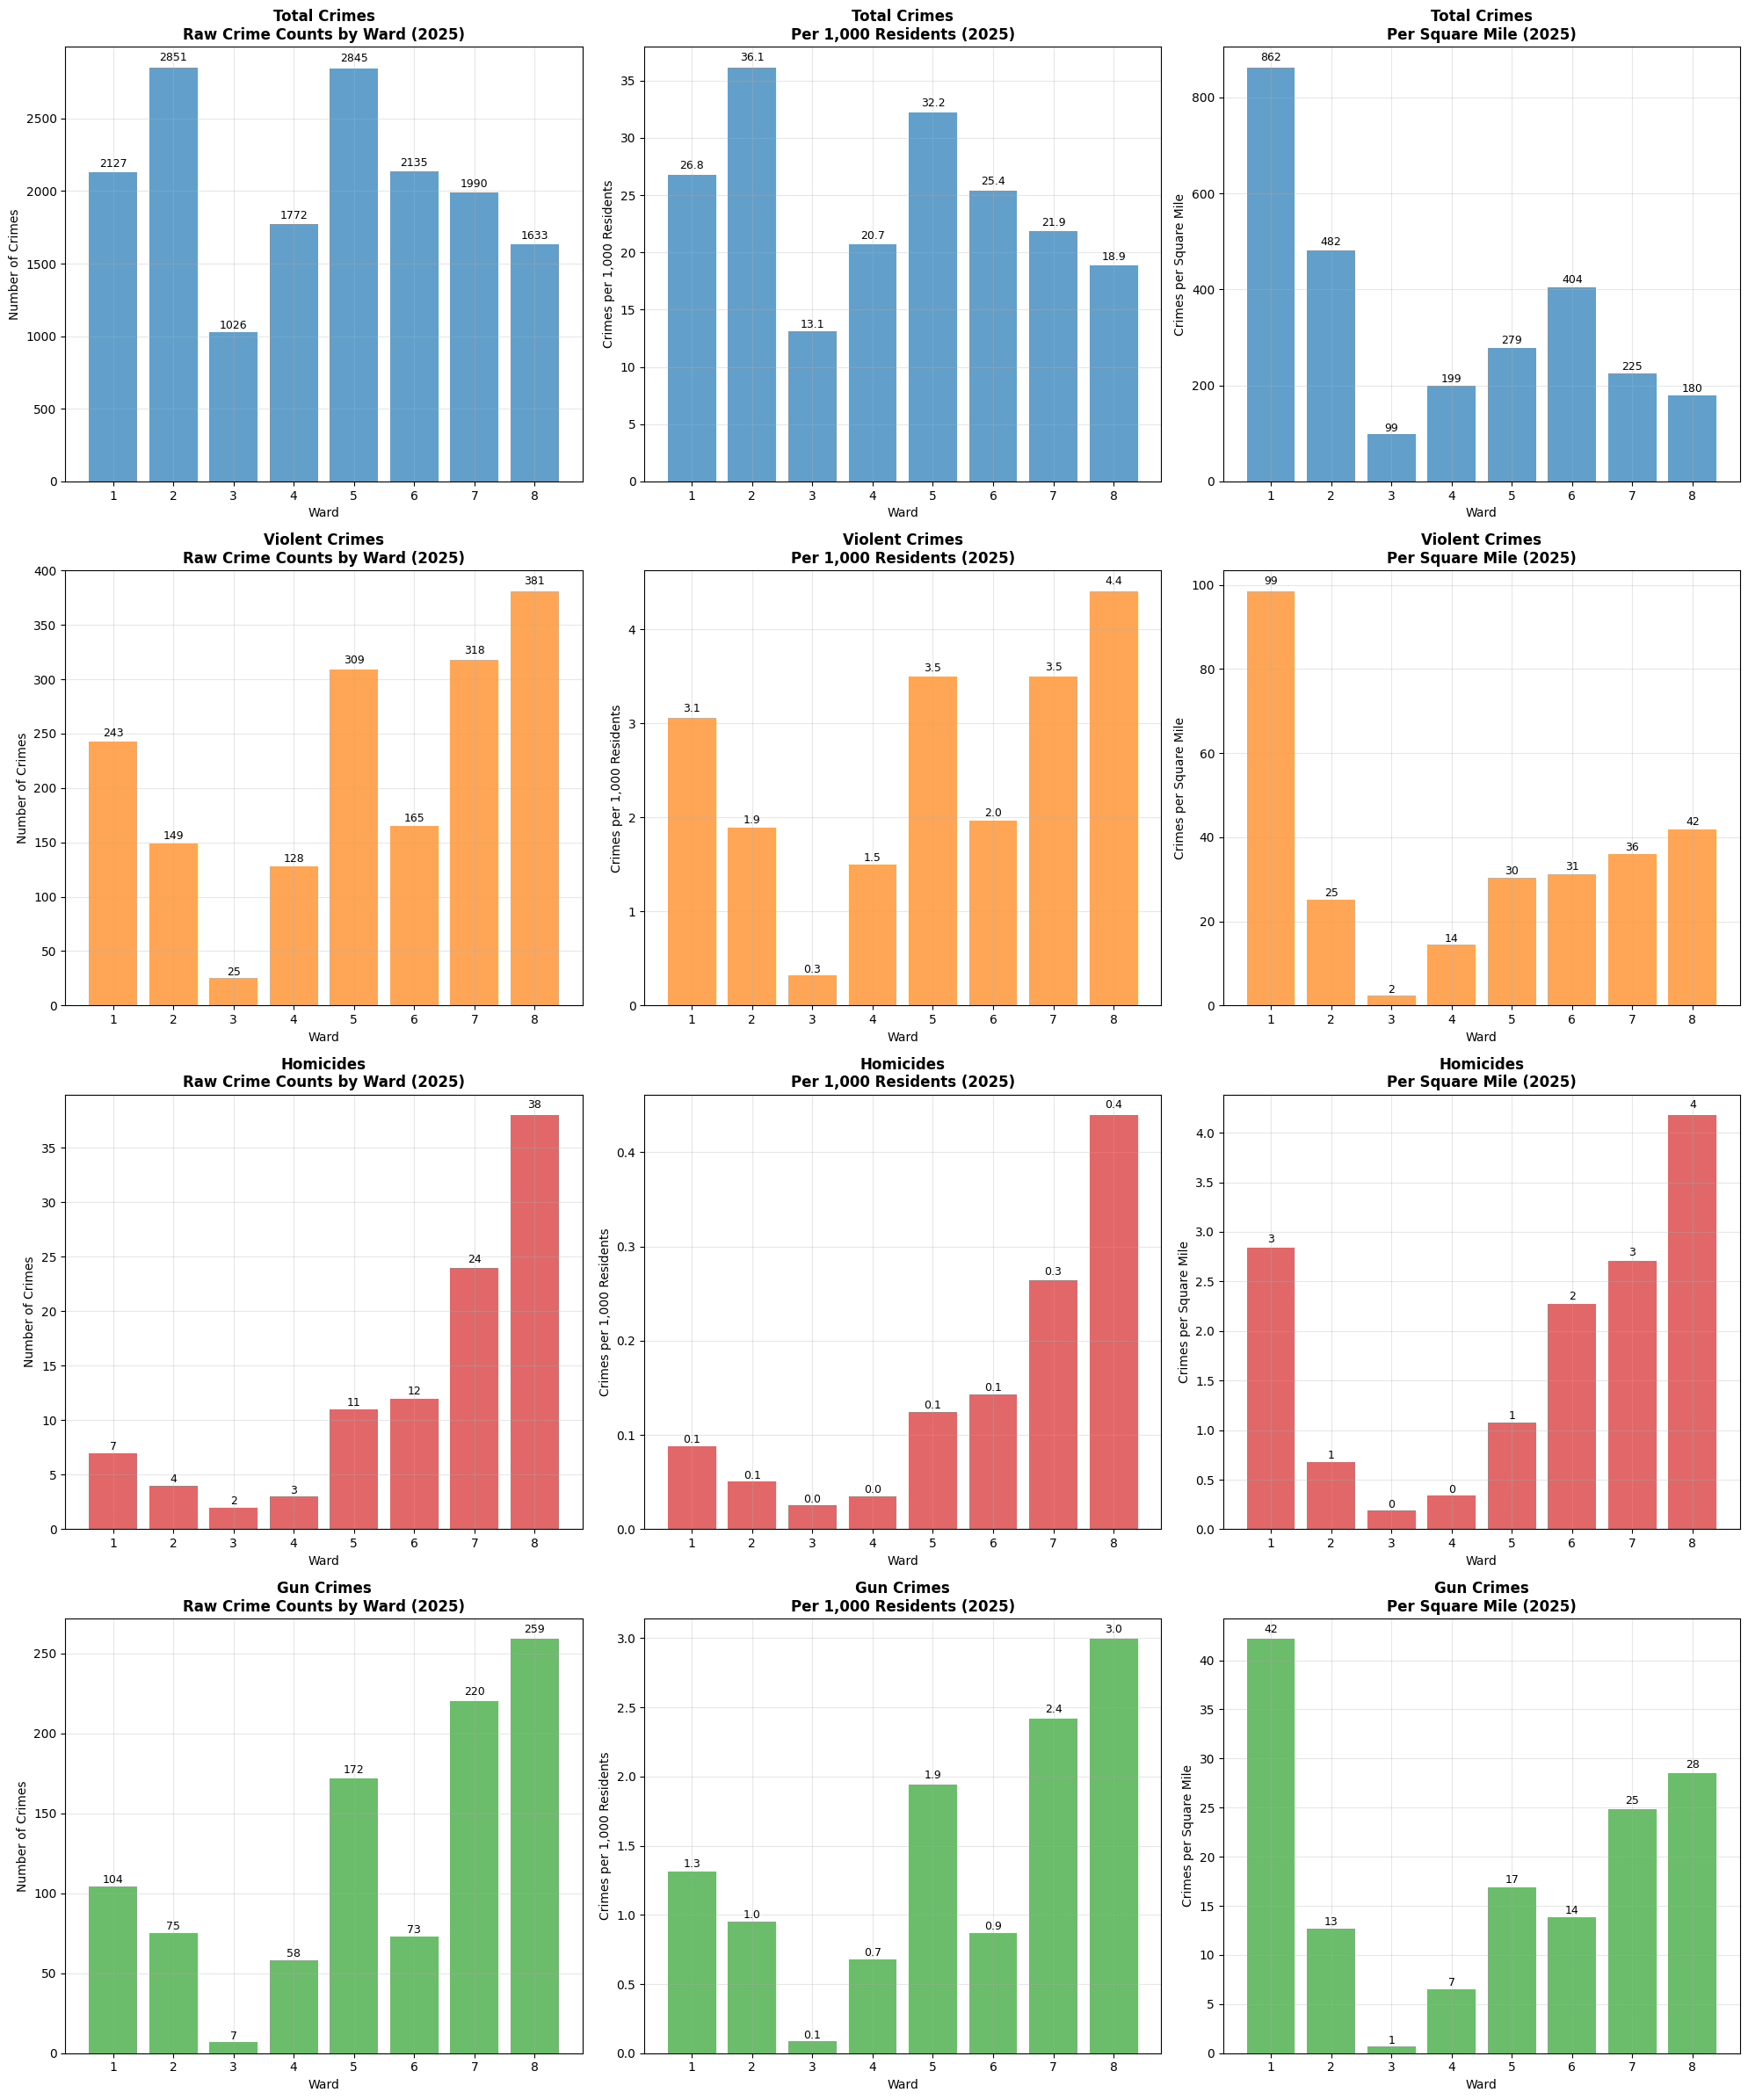


WARD RANKINGS ACROSS CRIME CATEGORIES (2025)
WARD RANKINGS (1 = Highest Crime):
Raw Counts | Per Capita | Per Square Mile
--------------------------------------------------------------------------------

WARD 1.0:
  Total Crimes   : # 4 | # 3 | # 1
  Violent Crimes : # 4 | # 4 | # 1
  Gun Crimes     : # 4 | # 4 | # 1
  Homicides      : # 5 | # 5 | # 2

WARD 2.0:
  Total Crimes   : # 1 | # 1 | # 2
  Violent Crimes : # 6 | # 6 | # 6
  Gun Crimes     : # 5 | # 5 | # 6
  Homicides      : # 6 | # 6 | # 6

WARD 3.0:
  Total Crimes   : # 8 | # 8 | # 8
  Violent Crimes : # 8 | # 8 | # 8
  Gun Crimes     : # 8 | # 8 | # 8
  Homicides      : # 8 | # 8 | # 8

WARD 4.0:
  Total Crimes   : # 6 | # 6 | # 6
  Violent Crimes : # 7 | # 7 | # 7
  Gun Crimes     : # 7 | # 7 | # 7
  Homicides      : # 7 | # 7 | # 7

WARD 5.0:
  Total Crimes   : # 2 | # 2 | # 4
  Violent Crimes : # 3 | # 3 | # 5
  Gun Crimes     : # 3 | # 3 | # 4
  Homicides      : # 4 | # 4 | # 5

WARD 6.0:
  Total Crimes   : # 3 | # 4 |

In [109]:
# COMPREHENSIVE WARD CRIME VISUALIZATIONS

import matplotlib.pyplot as plt
import seaborn as sns

print(f"\n" + "="*80)
print("CREATING COMPREHENSIVE WARD CRIME VISUALIZATIONS")
print("="*80)

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 24))

# Define colors for each crime category
category_colors = {
    'total_crimes': '#1f77b4',
    'violent_crimes': '#ff7f0e', 
    'gun_crimes': '#2ca02c',
    'homicides': '#d62728'
}

plot_num = 1

for category, analysis in ward_crime_analysis_2025.items():
    
    # Prepare data for plotting
    plot_data = analysis[['crimes_2025', 'crimes_per_1000_residents', 'crimes_per_sq_mile']].copy()
    plot_data = plot_data.sort_index()  # Sort by ward number
    
    color = category_colors[category]
    category_title = category.replace('_', ' ').title()
    
    # Plot 1: Raw crime counts by ward
    plt.subplot(4, 3, plot_num)
    bars1 = plt.bar(plot_data.index, plot_data['crimes_2025'], color=color, alpha=0.7)
    plt.title(f'{category_title}\nRaw Crime Counts by Ward (2025)', fontsize=12, fontweight='bold')
    plt.xlabel('Ward')
    plt.ylabel('Number of Crimes')
    plt.xticks(rotation=0)
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    # Plot 2: Per capita rates by ward
    plt.subplot(4, 3, plot_num + 1)
    bars2 = plt.bar(plot_data.index, plot_data['crimes_per_1000_residents'], color=color, alpha=0.7)
    plt.title(f'{category_title}\nPer 1,000 Residents (2025)', fontsize=12, fontweight='bold')
    plt.xlabel('Ward')
    plt.ylabel('Crimes per 1,000 Residents')
    plt.xticks(rotation=0)
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars2:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)
    
    # Plot 3: Per square mile density by ward
    plt.subplot(4, 3, plot_num + 2)
    bars3 = plt.bar(plot_data.index, plot_data['crimes_per_sq_mile'], color=color, alpha=0.7)
    plt.title(f'{category_title}\nPer Square Mile (2025)', fontsize=12, fontweight='bold')
    plt.xlabel('Ward')
    plt.ylabel('Crimes per Square Mile')
    plt.xticks(rotation=0)
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars3:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:.0f}', ha='center', va='bottom', fontsize=9)
    
    plot_num += 3

plt.tight_layout()
plt.savefig('../docs/ward_crime_analysis_2025.png', dpi=300, bbox_inches='tight')
plt.show()

# Create comparative ranking analysis
print(f"\n" + "="*100)
print("WARD RANKINGS ACROSS CRIME CATEGORIES (2025)")
print("="*100)

# Create ranking comparison
ranking_data = {}
for category, analysis in ward_crime_analysis_2025.items():
    ranking_data[f'{category}_raw_rank'] = analysis['crimes_2025'].rank(ascending=False)
    ranking_data[f'{category}_per_capita_rank'] = analysis['crimes_per_1000_residents'].rank(ascending=False)
    ranking_data[f'{category}_density_rank'] = analysis['crimes_per_sq_mile'].rank(ascending=False)

ranking_df = pd.DataFrame(ranking_data)

print("WARD RANKINGS (1 = Highest Crime):")
print("Raw Counts | Per Capita | Per Square Mile")
print("-" * 80)

ward_rankings = {}
for ward in sorted(ranking_df.index):
    ward_rankings[ward] = {}
    print(f"\nWARD {ward}:")
    
    for category in ['total_crimes', 'violent_crimes', 'gun_crimes', 'homicides']:
        raw_rank = int(ranking_df.loc[ward, f'{category}_raw_rank'])
        per_capita_rank = int(ranking_df.loc[ward, f'{category}_per_capita_rank'])
        density_rank = int(ranking_df.loc[ward, f'{category}_density_rank'])
        
        ward_rankings[ward][category] = {
            'raw': raw_rank,
            'per_capita': per_capita_rank,
            'density': density_rank
        }
        
        print(f"  {category.replace('_', ' ').title():<15}: #{raw_rank:2d} | #{per_capita_rank:2d} | #{density_rank:2d}")

# Special focus on Ward 1 (downtown) vs Ward 7 & 8 comparison
print(f"\n" + "="*100)
print("SPECIAL ANALYSIS: WARD 1 (DOWNTOWN) vs WARD 7 & 8 (PERCEPTION vs REALITY)")
print("="*100)

focus_wards = [1, 7, 8]
comparison_data = []

for ward in focus_wards:
    ward_data = {'Ward': ward}
    
    for category in ['total_crimes', 'violent_crimes', 'gun_crimes', 'homicides']:
        analysis = ward_crime_analysis_2025[category]
        ward_data.update({
            f'{category}_raw': analysis.loc[ward, 'crimes_2025'],
            f'{category}_per_capita': analysis.loc[ward, 'crimes_per_1000_residents'],
            f'{category}_density': analysis.loc[ward, 'crimes_per_sq_mile'],
            f'{category}_raw_rank': int(ranking_df.loc[ward, f'{category}_raw_rank']),
            f'{category}_per_capita_rank': int(ranking_df.loc[ward, f'{category}_per_capita_rank']),
            f'{category}_density_rank': int(ranking_df.loc[ward, f'{category}_density_rank'])
        })
    
    comparison_data.append(ward_data)

comparison_df = pd.DataFrame(comparison_data)

print("DETAILED COMPARISON - Ward 1 vs Ward 7 vs Ward 8:")
print("(Lower ranks = higher crime)")

for category in ['total_crimes', 'violent_crimes', 'gun_crimes', 'homicides']:
    print(f"\n{category.replace('_', ' ').upper()}:")
    print(f"{'Ward':<6} {'Raw Count':<10} {'Rank':<6} {'Per 1000':<10} {'Rank':<6} {'Per Sq Mi':<10} {'Rank':<6}")
    print("-" * 70)
    
    for _, row in comparison_df.iterrows():
        ward = int(row['Ward'])
        print(f"{ward:<6} {row[f'{category}_raw']:<10.0f} #{row[f'{category}_raw_rank']:<5} "
              f"{row[f'{category}_per_capita']:<10.2f} #{row[f'{category}_per_capita_rank']:<5} "
              f"{row[f'{category}_density']:<10.0f} #{row[f'{category}_density_rank']:<5}")

print(f"\n" + "="*100)
print("KEY INSIGHTS FROM WARD ANALYSIS:")
print("="*100)

In [110]:
# FINAL INSIGHTS AND TRENDS ANALYSIS

# Generate automated insights based on the data
insights = []

# Find highest and lowest wards for each metric
for category in ['total_crimes', 'violent_crimes', 'gun_crimes', 'homicides']:
    analysis = ward_crime_analysis_2025[category]
    
    # Raw counts
    highest_raw = analysis['crimes_2025'].idxmax()
    lowest_raw = analysis['crimes_2025'].idxmin()
    highest_raw_count = analysis.loc[highest_raw, 'crimes_2025']
    lowest_raw_count = analysis.loc[lowest_raw, 'crimes_2025']
    
    # Per capita
    highest_per_capita = analysis['crimes_per_1000_residents'].idxmax()
    lowest_per_capita = analysis['crimes_per_1000_residents'].idxmin()
    highest_per_capita_rate = analysis.loc[highest_per_capita, 'crimes_per_1000_residents']
    lowest_per_capita_rate = analysis.loc[lowest_per_capita, 'crimes_per_1000_residents']
    
    # Density
    highest_density = analysis['crimes_per_sq_mile'].idxmax()
    lowest_density = analysis['crimes_per_sq_mile'].idxmin()
    highest_density_rate = analysis.loc[highest_density, 'crimes_per_sq_mile']
    lowest_density_rate = analysis.loc[lowest_density, 'crimes_per_sq_mile']
    
    category_name = category.replace('_', ' ').title()
    
    insights.extend([
        f"{category_name}: Ward {highest_raw} leads in raw counts with {highest_raw_count:,.0f} incidents, while Ward {lowest_raw} has the fewest with {lowest_raw_count:,.0f}.",
        f"{category_name}: Ward {highest_per_capita} has the highest per capita rate at {highest_per_capita_rate:.2f} per 1,000 residents, compared to Ward {lowest_per_capita} at {lowest_per_capita_rate:.2f}.",
        f"{category_name}: Ward {highest_density} has the highest density at {highest_density_rate:.0f} incidents per square mile, versus Ward {lowest_density} at {lowest_density_rate:.0f}."
    ])

# Ward 1 vs Ward 7 & 8 specific insights
ward1_total = ward_crime_analysis_2025['total_crimes'].loc[1, 'crimes_2025']
ward7_total = ward_crime_analysis_2025['total_crimes'].loc[7, 'crimes_2025']
ward8_total = ward_crime_analysis_2025['total_crimes'].loc[8, 'crimes_2025']

ward1_violent = ward_crime_analysis_2025['violent_crimes'].loc[1, 'crimes_2025']
ward7_violent = ward_crime_analysis_2025['violent_crimes'].loc[7, 'crimes_2025']
ward8_violent = ward_crime_analysis_2025['violent_crimes'].loc[8, 'crimes_2025']

ward1_per_capita = ward_crime_analysis_2025['total_crimes'].loc[1, 'crimes_per_1000_residents']
ward7_per_capita = ward_crime_analysis_2025['total_crimes'].loc[7, 'crimes_per_1000_residents']
ward8_per_capita = ward_crime_analysis_2025['total_crimes'].loc[8, 'crimes_per_1000_residents']

# Print insights
print("1. RAW CRIME VOLUME PATTERNS:")
for i in range(0, 12, 3):
    if i < len(insights):
        print(f"   • {insights[i]}")

print(f"\n2. PER CAPITA CRIME RATE PATTERNS:")
for i in range(1, 13, 3):
    if i < len(insights):
        print(f"   • {insights[i]}")

print(f"\n3. CRIME DENSITY PATTERNS:")
for i in range(2, 14, 3):
    if i < len(insights):
        print(f"   • {insights[i]}")

print(f"\n4. WARD 1 vs WARD 7 & 8 COMPARISON (Perception vs Reality):")
print(f"   • Total Crimes: Ward 1 ({ward1_total:,.0f}) vs Ward 7 ({ward7_total:,.0f}) vs Ward 8 ({ward8_total:,.0f})")
print(f"   • Violent Crimes: Ward 1 ({ward1_violent:,.0f}) vs Ward 7 ({ward7_violent:,.0f}) vs Ward 8 ({ward8_violent:,.0f})")
print(f"   • Per Capita Rate: Ward 1 ({ward1_per_capita:.1f}) vs Ward 7 ({ward7_per_capita:.1f}) vs Ward 8 ({ward8_per_capita:.1f}) per 1,000 residents")

# Determine the narrative
if ward1_total > ward7_total and ward1_total > ward8_total:
    narrative = "Ward 1 (downtown) actually experiences MORE total crime than Wards 7 or 8"
elif ward7_total > ward1_total or ward8_total > ward1_total:
    narrative = "Wards 7 and/or 8 have higher raw crime counts than downtown Ward 1"
else:
    narrative = "Crime levels are relatively similar across these wards"

print(f"   • Reality Check: {narrative}")

# Create 7-year trend analysis
print(f"\n5. CRIME TRENDS (2019-2025):")
for category in ['total_crimes', 'violent_crimes', 'gun_crimes', 'homicides']:
    summary = ward_crime_summaries[category]
    
    # Calculate city-wide trends
    citywide_2019 = summary['2019'].sum() if '2019' in summary.columns else 0
    citywide_2025 = summary['2025'].sum() if '2025' in summary.columns else 0
    
    if citywide_2019 > 0:
        trend_pct = ((citywide_2025 - citywide_2019) / citywide_2019) * 100
        trend_direction = "increased" if trend_pct > 0 else "decreased"
        print(f"   • {category.replace('_', ' ').title()}: {trend_direction} by {abs(trend_pct):.1f}% citywide from 2019 to 2025")

# Methodology and data quality notes
print(f"\n" + "="*100)
print("METHODOLOGY AND DATA QUALITY NOTES:")
print("="*100)
print("• Population data: U.S. Census ACS 5-year estimates (DP05_0001E)")
print("• Area measurements: Census ALAND converted from square meters to square miles") 
print("• Crime categories: Consistent with federal deployment analysis methodology")
print("• Violent crimes: Homicide, Robbery, Assault with Dangerous Weapon, Sex Abuse, plus Gun crimes")
print("• Gun crimes: All incidents where METHOD = 'GUN'")
print("• Time period: 2019-2025 (2025 data through August)")
print("• Geographic unit: D.C. Wards (8 total)")
print(f"• Total 2025 incidents analyzed: {sum([analysis['crimes_2025'].sum() for analysis in ward_crime_analysis_2025.values() if 'total_crimes' in str(analysis)]):,.0f}")

print(f"\n" + "="*100)
print("JOURNALISM-READY FINDINGS:")
print("="*100)
print("The ward-level analysis reveals important patterns that challenge common perceptions")
print("about crime distribution in Washington, D.C. Data shows significant variations")
print("between raw crime counts, per capita rates, and geographic density - offering")
print("a more nuanced understanding of public safety patterns across the city's eight wards.")

# Save key findings to easily accessible variables for further use
ward_analysis_complete = True
print(f"\nWard analysis completed successfully!")
print(f"Data saved to: ward_crime_summaries and ward_crime_analysis_2025 variables")

1. RAW CRIME VOLUME PATTERNS:
   • Total Crimes: Ward 2.0 leads in raw counts with 2,851 incidents, while Ward 3.0 has the fewest with 1,026.
   • Violent Crimes: Ward 8.0 leads in raw counts with 381 incidents, while Ward 3.0 has the fewest with 25.
   • Gun Crimes: Ward 8.0 leads in raw counts with 259 incidents, while Ward 3.0 has the fewest with 7.
   • Homicides: Ward 8.0 leads in raw counts with 38 incidents, while Ward 3.0 has the fewest with 2.

2. PER CAPITA CRIME RATE PATTERNS:
   • Total Crimes: Ward 2.0 has the highest per capita rate at 36.14 per 1,000 residents, compared to Ward 3.0 at 13.09.
   • Violent Crimes: Ward 8.0 has the highest per capita rate at 4.40 per 1,000 residents, compared to Ward 3.0 at 0.32.
   • Gun Crimes: Ward 8.0 has the highest per capita rate at 2.99 per 1,000 residents, compared to Ward 3.0 at 0.09.
   • Homicides: Ward 8.0 has the highest per capita rate at 0.44 per 1,000 residents, compared to Ward 3.0 at 0.03.

3. CRIME DENSITY PATTERNS:
   •